In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel  # Add this import
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')




In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
RANDOM_STATE = 69

np.random.seed(RANDOM_STATE)
sns.set(style='whitegrid')


Data shape: (150000, 11)

First 5 records:
   seriousdlqin2yrs  revolvingutilizationofunsecuredlines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   numberoftime3059dayspastduenotworse  debtratio  monthlyincome  \
0                                    2   0.802982         9120.0   
1                                    0   0.121876         2600.0   
2                                    1   0.085113         3042.0   
3                                    0   0.036050         3300.0   
4                                    1   0.024926        63588.0   

   numberofopencreditlinesandloans  numberoftimes90dayslate  \
0                               13                        0   
1                        

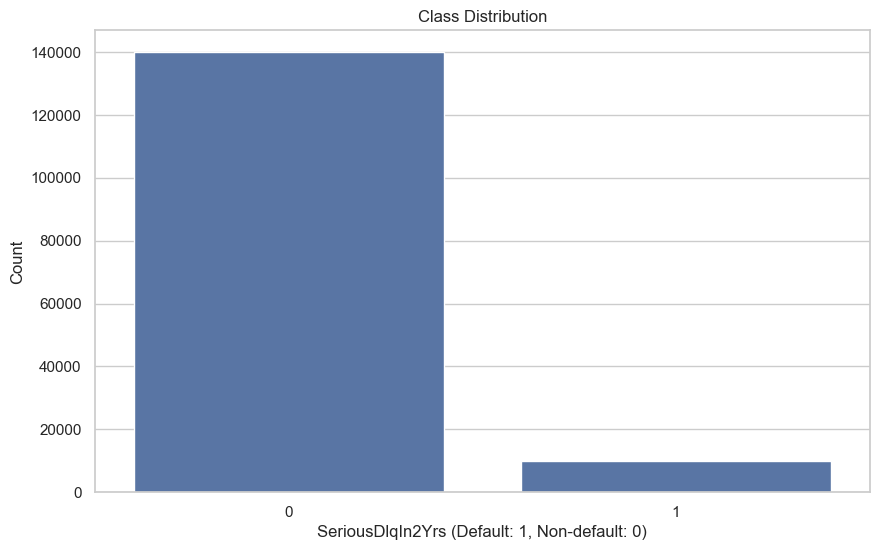

In [5]:
# Load the data
training_data = pd.read_csv('data/cs-training.csv')


# Drop the index column
if 'Unnamed: 0' in training_data.columns:
    training_data = training_data.drop('Unnamed: 0', axis=1)

# Clean column names
training_data.columns = [col.replace('-', '').lower() for col in training_data.columns]

# Display data information
print(f"Data shape: {training_data.shape}")
print("\nFirst 5 records:")
print(training_data.head())

# Check missing values
missing_values = training_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Display descriptive statistics
print("\nDescriptive statistics:")
print(training_data.describe().T)

# Check target variable distribution
target_dist = training_data['seriousdlqin2yrs'].value_counts()
print("\nTarget distribution:")
print(target_dist)
print(f"Default rate: {target_dist[1]/len(training_data):.2%}")

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='seriousdlqin2yrs', data=training_data)
plt.title('Class Distribution')
plt.xlabel('SeriousDlqIn2Yrs (Default: 1, Non-default: 0)')
plt.ylabel('Count')
plt.show()

In [6]:
# Handle missing values before any processing
# Fill missing values for monthlyincome with median
median_income = training_data['monthlyincome'].median()
training_data['monthlyincome'] = training_data['monthlyincome'].fillna(median_income)

# Fill missing values for numberofdependents with median
median_dependents = training_data['numberofdependents'].median()
training_data['numberofdependents'] = training_data['numberofdependents'].fillna(median_dependents)

# Verify no missing values remain
print("Missing values after imputation:")
print(training_data.isnull().sum())

Missing values after imputation:
seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
numberoftime3059dayspastduenotworse     0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime6089dayspastduenotworse     0
numberofdependents                      0
dtype: int64


In [8]:
# Separate features and target
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data['seriousdlqin2yrs']

# Create new features
def create_features(df):
    df_new = df.copy()
    
    # Utilization to income ratio
    df_new['util_to_income'] = df_new['revolvingutilizationofunsecuredlines'] / df_new['monthlyincome'].replace(0, 0.001)
    
    # Age groups (binned)
    df_new['age_group'] = pd.cut(df_new['age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=[0, 1, 2, 3, 4, 5])
    
    # Delinquency features
    df_new['total_delinquencies'] = (df_new['numberoftime3059dayspastduenotworse'] + 
                                    df_new['numberoftime6089dayspastduenotworse'] + 
                                    df_new['numberoftimes90dayslate'])
    
    # Has delinquency flag
    df_new['has_delinquency'] = (df_new['total_delinquencies'] > 0).astype(int)
    
    # Credit lines to income ratio
    df_new['credit_lines_to_income'] = df_new['numberofopencreditlinesandloans'] / df_new['monthlyincome'].replace(0, 0.001)
    
    # Real estate loans to total credit lines ratio
    df_new['realestate_to_credit_ratio'] = df_new['numberrealestateloansorlines'] / df_new['numberofopencreditlinesandloans'].replace(0, 0.001)
    
    # High utilization flag
    df_new['high_utilization'] = (df_new['revolvingutilizationofunsecuredlines'] > 0.5).astype(int)
    
    # Income per dependent 
    df_new['income_per_dependent'] = df_new['monthlyincome'] / (df_new['numberofdependents'] + 1)
    
    # Compute logarithmic transforms for skewed features
    for feature in ['revolvingutilizationofunsecuredlines', 'debtratio', 'monthlyincome', 'util_to_income']:
        # Add a small constant to avoid log(0)
        df_new[f'log_{feature}'] = np.log1p(df_new[feature].replace(0, 0.001))
        
    return df_new

# Apply feature engineering
X_engineered = create_features(X)

# List new features created
print("Features after engineering:")
print(X_engineered.columns.tolist())

Features after engineering:
['revolvingutilizationofunsecuredlines', 'age', 'numberoftime3059dayspastduenotworse', 'debtratio', 'monthlyincome', 'numberofopencreditlinesandloans', 'numberoftimes90dayslate', 'numberrealestateloansorlines', 'numberoftime6089dayspastduenotworse', 'numberofdependents', 'util_to_income', 'age_group', 'total_delinquencies', 'has_delinquency', 'credit_lines_to_income', 'realestate_to_credit_ratio', 'high_utilization', 'income_per_dependent', 'log_revolvingutilizationofunsecuredlines', 'log_debtratio', 'log_monthlyincome', 'log_util_to_income']


In [9]:
# Fill numeric columns with median
numeric_cols = X_engineered.select_dtypes(include=['number']).columns
X_engineered[numeric_cols] = X_engineered[numeric_cols].fillna(X_engineered[numeric_cols].median())

# Fill categorical columns with mode
categorical_cols = X_engineered.select_dtypes(include=['category']).columns
for col in categorical_cols:
    if X_engineered[col].isnull().sum() > 0:
        X_engineered[col] = X_engineered[col].fillna(X_engineered[col].mode()[0])

# Verify no missing values remain
print("Missing values after imputation:")
print(X_engineered.isnull().sum().sum())

Missing values after imputation:
0


In [10]:
print(X_engineered)

        revolvingutilizationofunsecuredlines  age  \
0                                   0.766127   45   
1                                   0.957151   40   
2                                   0.658180   38   
3                                   0.233810   30   
4                                   0.907239   49   
...                                      ...  ...   
149995                              0.040674   74   
149996                              0.299745   44   
149997                              0.246044   58   
149998                              0.000000   30   
149999                              0.850283   64   

        numberoftime3059dayspastduenotworse    debtratio  monthlyincome  \
0                                         2     0.802982         9120.0   
1                                         0     0.121876         2600.0   
2                                         1     0.085113         3042.0   
3                                         0     0.036050       

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (120000, 22)
Test set shape: (30000, 22)


yay

Top 15 features by importance:
                                     feature  importance
18  log_revolvingutilizationofunsecuredlines    0.090070
13                           has_delinquency    0.085478
0       revolvingutilizationofunsecuredlines    0.085456
10                            util_to_income    0.071379
12                       total_delinquencies    0.062662
21                        log_util_to_income    0.058748
19                             log_debtratio    0.056066
3                                  debtratio    0.055298
1                                        age    0.054544
14                    credit_lines_to_income    0.050685
17                      income_per_dependent    0.046432
20                         log_monthlyincome    0.038546
4                              monthlyincome    0.038463
5            numberofopencreditlinesandloans    0.034077
16                          high_utilization    0.033572


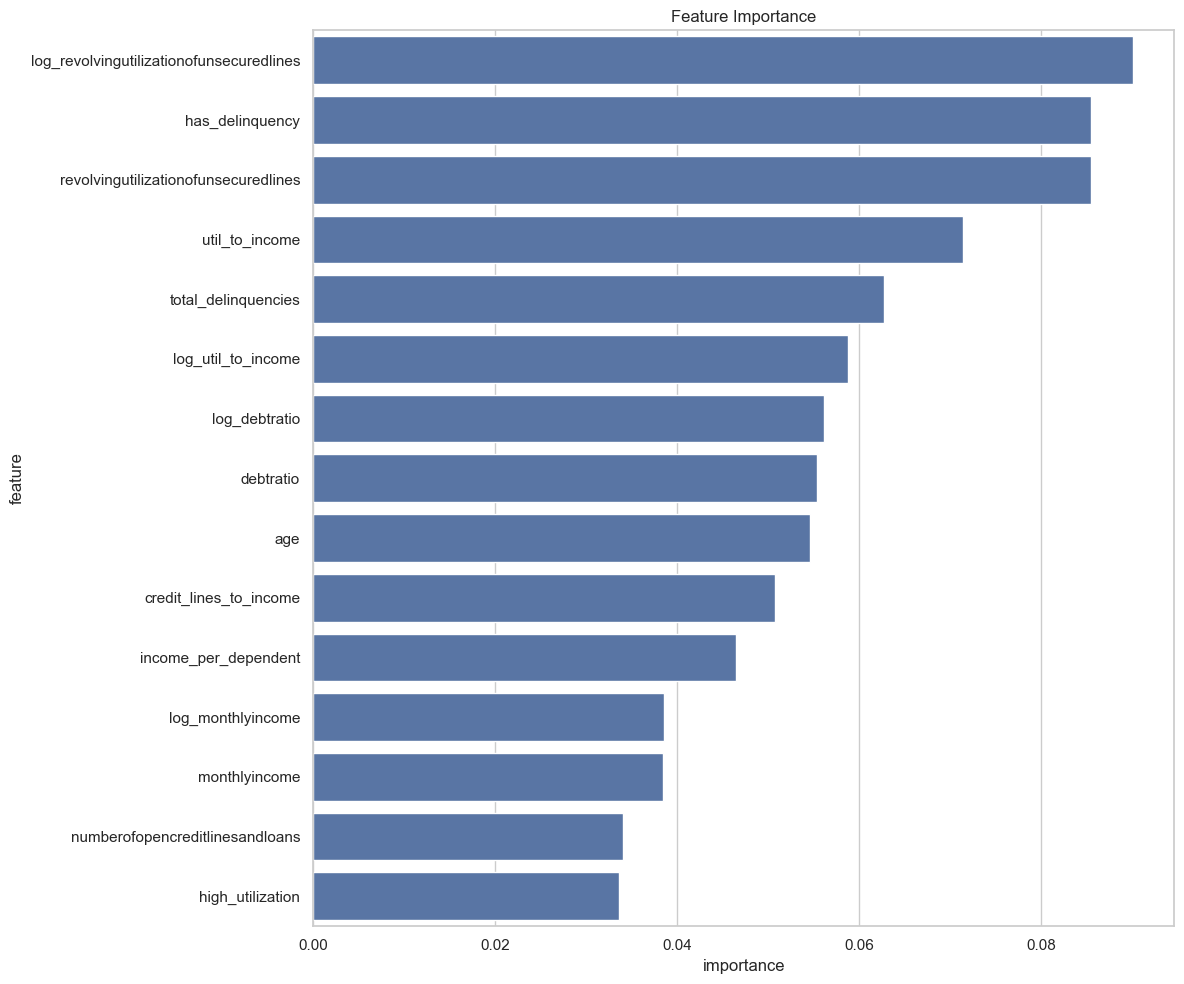


Selected features:
['revolvingutilizationofunsecuredlines', 'age', 'debtratio', 'util_to_income', 'total_delinquencies', 'has_delinquency', 'credit_lines_to_income', 'income_per_dependent', 'log_revolvingutilizationofunsecuredlines', 'log_debtratio', 'log_util_to_income']


In [12]:
# Use Random Forest to rank features by importance
print("yay")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
rf_selector.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Display top features
print("\nTop 15 features by importance:")
print(feature_importances.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Select features using SelectFromModel
selector = SelectFromModel(rf_selector, threshold='mean')
selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.get_support()]
print("\nSelected features:")
print(selected_features.tolist())

# Filter datasets to selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Convert back to dataframes with feature names
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

In [13]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.5)  # Create a more balanced dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# Check class distribution after SMOTE
print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")

Class distribution after SMOTE: seriousdlqin2yrs
0    111979
1     55989
Name: count, dtype: int64


In [14]:
# Train a Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

balanced_rf.fit(X_train_resampled, y_train_resampled)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    scale_pos_weight=10,  # Adjust for class imbalance
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Train Random Forest on the resampled data
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=69)

Balanced Random Forest AUC: 0.8495


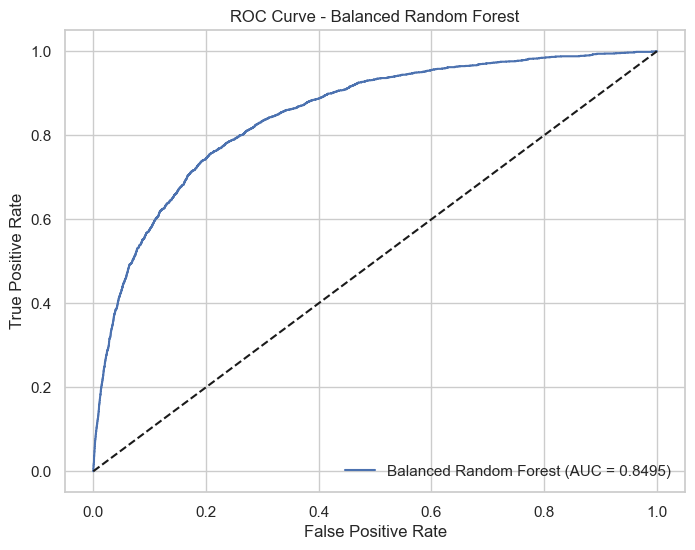

Optimal threshold: 0.7600

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27995
           1       0.36      0.48      0.41      2005

    accuracy                           0.91     30000
   macro avg       0.66      0.71      0.68     30000
weighted avg       0.92      0.91      0.91     30000



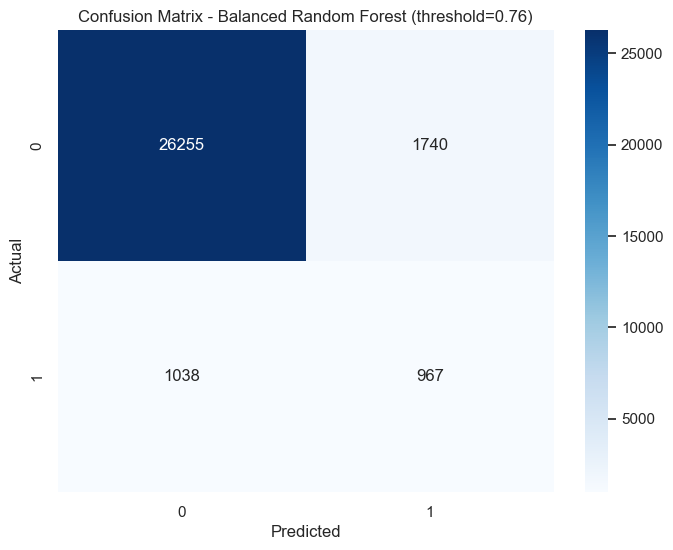

XGBoost AUC: 0.8499


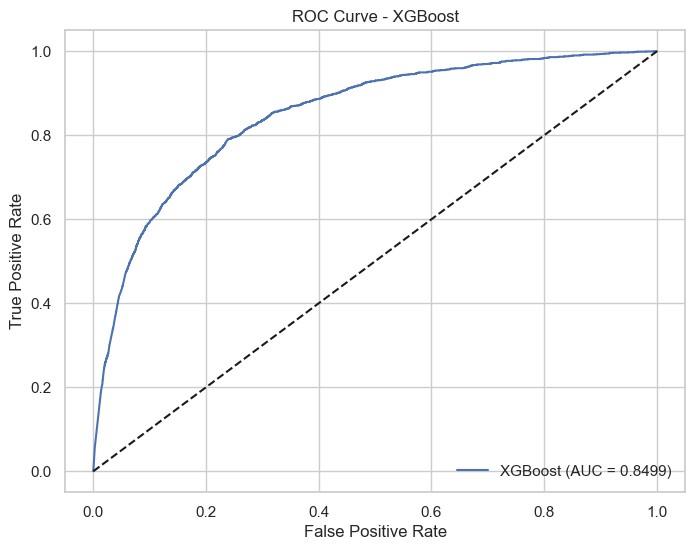

Optimal threshold: 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27995
           1       0.36      0.48      0.41      2005

    accuracy                           0.91     30000
   macro avg       0.66      0.71      0.68     30000
weighted avg       0.92      0.91      0.91     30000



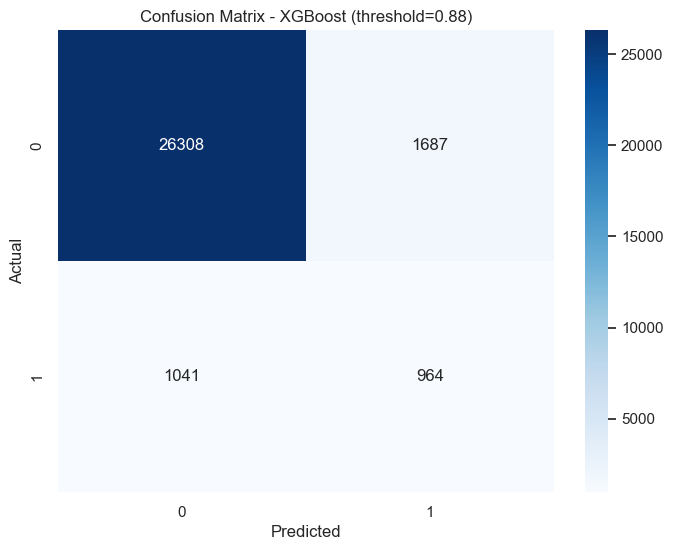

Random Forest AUC: 0.8496


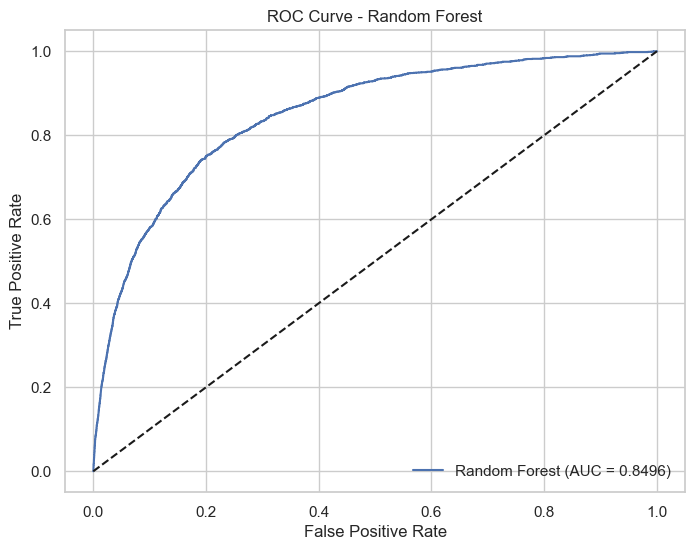

Optimal threshold: 0.6000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     27995
           1       0.35      0.50      0.41      2005

    accuracy                           0.90     30000
   macro avg       0.66      0.72      0.68     30000
weighted avg       0.92      0.90      0.91     30000



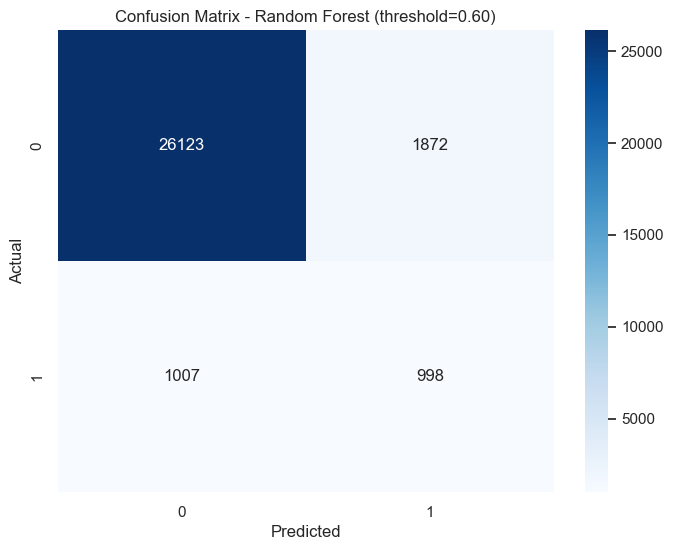

In [15]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} AUC: {auc_score:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Find optimal threshold based on F1 score
    thresholds = np.linspace(0.01, 0.99, 99)
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # Apply optimal threshold
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (threshold={optimal_threshold:.2f})')
    plt.show()
    
    return auc_score, y_pred_proba

# Evaluate individual models
_, y_pred_proba_balanced_rf = evaluate_model(balanced_rf, X_test_selected, y_test, "Balanced Random Forest")
_, y_pred_proba_xgb = evaluate_model(xgb_model, X_test_selected, y_test, "XGBoost")
_, y_pred_proba_rf = evaluate_model(rf_model, X_test_selected, y_test, "Random Forest")

Ensemble Model AUC: 0.8502


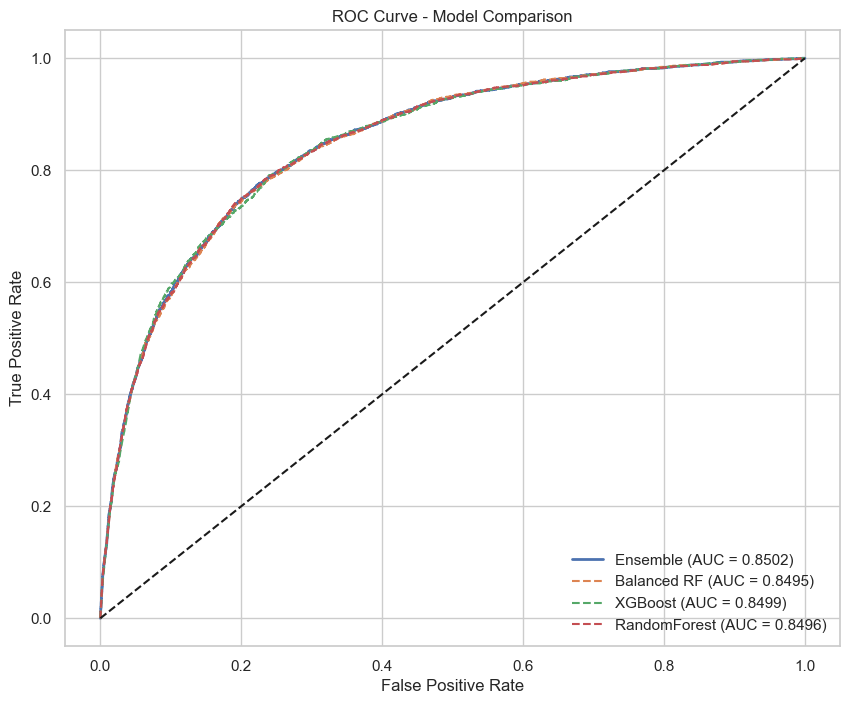

In [16]:
# Create weighted ensemble predictions
y_pred_proba_ensemble = (0.4 * y_pred_proba_balanced_rf + 
                         0.4 * y_pred_proba_xgb + 
                         0.2 * y_pred_proba_rf)

# Evaluate ensemble
auc_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble)
print(f"Ensemble Model AUC: {auc_ensemble:.4f}")

# Plot ROC curve for ensemble
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_proba_ensemble)
plt.figure(figsize=(10, 8))
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {auc_ensemble:.4f})', linewidth=2)

# Add individual models to the plot
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_pred_proba_balanced_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.plot(fpr_brf, tpr_brf, label=f'Balanced RF (AUC = {roc_auc_score(y_test, y_pred_proba_balanced_rf):.4f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Top 15 features by average importance:
                                     feature  avg_importance
5                            has_delinquency        0.419481
4                        total_delinquencies        0.261316
0       revolvingutilizationofunsecuredlines        0.106860
8   log_revolvingutilizationofunsecuredlines        0.061108
3                             util_to_income        0.054118
10                        log_util_to_income        0.042824
1                                        age        0.019641
6                     credit_lines_to_income        0.009259
2                                  debtratio        0.009117
9                              log_debtratio        0.008379
7                       income_per_dependent        0.007897


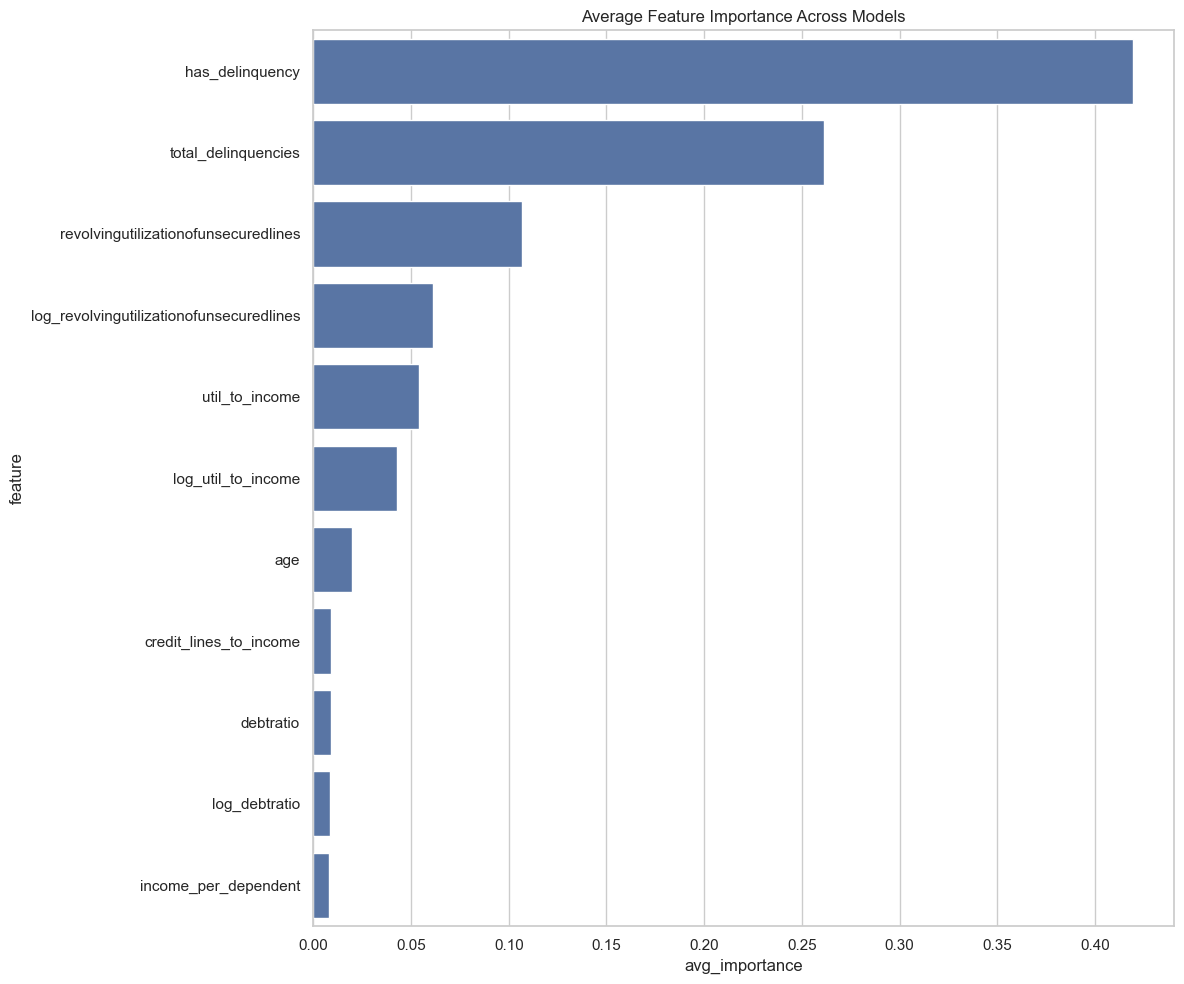

In [17]:
# Feature importance from each model
feature_imp_balanced_rf = pd.DataFrame({
    'feature': selected_features,
    'importance': balanced_rf.feature_importances_
}).sort_values('importance', ascending=False)

feature_imp_xgb = pd.DataFrame({
    'feature': selected_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_imp_rf = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Average feature importance across models
feature_imp_all = pd.DataFrame({'feature': selected_features})

# Normalize importances to sum to 1 for each model
feature_imp_balanced_rf['importance'] = feature_imp_balanced_rf['importance'] / feature_imp_balanced_rf['importance'].sum()
feature_imp_xgb['importance'] = feature_imp_xgb['importance'] / feature_imp_xgb['importance'].sum()
feature_imp_rf['importance'] = feature_imp_rf['importance'] / feature_imp_rf['importance'].sum()

# Merge and calculate average
feature_imp_all = feature_imp_all.merge(feature_imp_balanced_rf, on='feature', how='left', suffixes=('', '_brf'))
feature_imp_all = feature_imp_all.merge(feature_imp_xgb, on='feature', how='left', suffixes=('', '_xgb'))
feature_imp_all = feature_imp_all.merge(feature_imp_rf, on='feature', how='left', suffixes=('', '_rf'))

# Calculate weighted average importance
feature_imp_all['avg_importance'] = (0.4 * feature_imp_all['importance'] + 
                                    0.4 * feature_imp_all['importance_xgb'] + 
                                    0.2 * feature_imp_all['importance_rf'])

feature_imp_all = feature_imp_all[['feature', 'avg_importance']].sort_values('avg_importance', ascending=False)

print("\nTop 15 features by average importance:")
print(feature_imp_all.head(15))

# Visualize average feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='avg_importance', y='feature', data=feature_imp_all.head(15))
plt.title('Average Feature Importance Across Models')
plt.tight_layout()
plt.show()

In [18]:
# Check if we achieved our target AUC
if auc_ensemble >= 0.85:
    print("\nyay!!!.")
else:
    print("\nThe ensemble model achieved an AUC of {:.4f}, which is less than the target of 0.85.".format(auc_ensemble))
    print("Consider further tuning or alternative modeling approaches.")

print("\nKey insights:")
print("1. big factors for predicting credit risk:")
for i, row in feature_imp_all.head(5).iterrows():
    print(f"   - {row['feature']}: {row['avg_importance']:.4f}")
    
print("\n2. Model performance summary:")
print(f"   - Balanced Random Forest AUC: {roc_auc_score(y_test, y_pred_proba_balanced_rf):.4f}")
print(f"   - XGBoost AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"   - Random Forest AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"   - Ensemble AUC: {auc_ensemble:.4f}")


yay!!!.

Key insights:
1. big factors for predicting credit risk:
   - has_delinquency: 0.4195
   - total_delinquencies: 0.2613
   - revolvingutilizationofunsecuredlines: 0.1069
   - log_revolvingutilizationofunsecuredlines: 0.0611
   - util_to_income: 0.0541

2. Model performance summary:
   - Balanced Random Forest AUC: 0.8495
   - XGBoost AUC: 0.8499
   - Random Forest AUC: 0.8496
   - Ensemble AUC: 0.8502


In [19]:
import joblib

# Save models
joblib.dump(balanced_rf, 'balanced_rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')

# Save feature list and preprocessing info for future use
model_info = {
    'selected_features': selected_features.tolist(),
    'median_income': median_income,
    'median_dependents': median_dependents
}
joblib.dump(model_info, 'model_info.pkl')

['model_info.pkl']

In [20]:
# Save the trained models to disk
import os

# Create a directory to store models
if not os.path.exists('models'):
    os.makedirs('models')

# Save models
print("Saving models to disk...")
joblib.dump(balanced_rf, 'models/balanced_rf_model.pkl')
joblib.dump(xgb_model, 'models/xgb_model.pkl')
joblib.dump(rf_model, 'models/rf_model.pkl')

# Save preprocessing information
print("Saving preprocessing information...")
preprocessing_info = {
    'selected_features': selected_features.tolist(),
    'median_income': X['monthlyincome'].median(),
    'median_dependents': X['numberofdependents'].median()
}
joblib.dump(preprocessing_info, 'models/preprocessing_info.pkl')

print("Models and preprocessing info saved successfully!")

Saving models to disk...
Saving preprocessing information...
Models and preprocessing info saved successfully!
